In [2]:
import numpy as np
import itertools
import os

from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
'''Fungsi Interpolasi data'''

def interpolasi(min, max, i, xval, yval, delta):
    xnew = np.linspace(min, max, delta)
    spline = make_interp_spline(xval, yval, k=i)
    ynew = spline(xnew)
    return xnew, ynew

In [4]:
'''
Data tersedia online di drive dengan link:
https://drive.google.com/drive/folders/1prz4Sxx4Zq72kOdlj21b_F1evTodyqTE?usp=drive_link
'''

!gdown --folder --id 1prz4Sxx4Zq72kOdlj21b_F1evTodyqTE -O /
os.chdir('/RTDs barrier width variation data')

os.listdir()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1l9AmoqY2BS0ppl4g-iw_tEu5lv_CpI1E data_LB1.5_T273.npz
Processing file 1geW10cfBmzs11w4JQJGjjgvGCo85XdeN data_LB1.5_T300.npz
Processing file 1a5OtmgxPgR4r7tcRUAywHldHnkicHSB3 data_LB1.5_T323.npz
Processing file 1JDRpd-Q0TxmISuQCDkeVFoR9unXU-H2g data_LB2.0_T273.npz
Processing file 1Lz55jHxqbTPSh_Cjhq7zpbP29I0Q4Ej2 data_LB2.0_T300.npz
Processing file 1IGelaYT6C_CRhX138zyj8BdOh4S_6fsZ data_LB2.0_T323.npz
Processing file 1YppTEL7-SvXkyRWA1H9iyDpkzD5s83ar data_LB2.5_T273.npz
Processing file 1mv-LSX16NkYro0r7Xt-yB4gLUni4U6J6 data_LB2.5_T300.npz
Processing file 1xl99o4cvnxBDDoKcfn22NPbkgqQ6akTQ data_LB2.5_T323.npz
Processing file 1IiMBbQQ2rq8OukPsRc3ToG6QwEUcN8rG data_LB3.5_T273.npz
Processing file 1Vmd9VNBQkTtiLX3glO9I_0-A1kphoOkH da

['data_LB1.5_T323.npz',
 'data_LB6.5_T300.npz',
 'data_LB3.5_T300.npz',
 'data_LB4.0_T323.npz',
 'data_LB6.5_T323.npz',
 'data_LB2.0_T323.npz',
 'data_LB4.5_T273.npz',
 'data_LB4.5_T300.npz',
 'data_LB6.5_T273.npz',
 'data_LB5.0_T323.npz',
 'data_LB3.5_T273.npz',
 'data_LB4.0_T300.npz',
 'data_LB1.5_T300.npz',
 'data_LB4.5_T323.npz',
 'data_LB2.5_T300.npz',
 'data_LB2.0_T300.npz',
 'data_LB5.5_T300.npz',
 'data_LB5.0_T300.npz',
 'data_LB2.5_T323.npz',
 'data_LB5.5_T273.npz',
 'data_LB2.0_T273.npz',
 'data_LB5.5_T323.npz',
 'data_LB2.5_T273.npz',
 'data_LB3.5_T323.npz',
 'data_LB5.0_T273.npz',
 'data_LB1.5_T273.npz',
 'data_LB4.0_T273.npz']

In [144]:
# Load data dari file npz
LebarPenghalang = [1.5, 2.0, 2.5, 3.5, 4.0, 4.5, 5.0, 5.5, 6.5]
Temperature = [300]

'''
Load data dari file npz dengan nama yang sesuai dengan parameter yang digunakan.
Penamaan Hasil Load Data Mengacu Sebagai Berikut:
x_LB1_5_T300 : array posisi x untuk Lebar Penghalang 1.5 nm dan Temperatur 300 K.
J_LB2_T300 : array kerapatan arus untuk Lebar Penghalang 2 nm dan Temperatur 300 K.
dan seterusnya....
'''

for i in LebarPenghalang:
  for T in Temperature:
    filename = f"data_LB{i}_T{T}.npz"
    data = np.load(filename)
    variable = {f"{var}_LB{str(i).replace('.', '_')}_T{T}": data[var] for var in ['x', 'Vbias', 'E', 'Ef', 'pot', 'nilai_transmisi', 'J']}
    globals().update(variable)

#Variabel yang sama
Ti = Temperature[0]
Vbias   = eval(f'Vbias_LB1_5_T{Ti}')
Energi  = eval(f'E_LB1_5_T{Ti}')
Ef      = eval(f'Ef_LB1_5_T{Ti}')

In [145]:
print(f'E0        : {Energi[0]:.8f} eV \nEf(T={Ti}) : {Ef:.8f} eV')
EF0 = (Ef + np.sqrt(Ef*Ef + np.pi**2 /3 *(8.617343*10**(-5) *Ti)**2))/2
print(f'Ef0       : {EF0:.8f} eV')
TF = EF0/(8.617343*10**(-5))
print(f'TF        : {TF:.8f} K')

E0        : 1.42257143 eV 
Ef(T=300) : 1.45792286 eV
Ef0       : 1.45829979 eV
TF        : 16922.84725651 K


#Profil Potensial dan Koefisien Transmisi Elektron

In [146]:
'''Tebakan bias yang ingin diplot'''
biasplot   = 0.12
n          = np.argmin(np.abs(Vbias - biasplot))
Vplot      = Vbias[n]
biasplot2  = 0.24
n2         = np.argmin(np.abs(Vbias - biasplot2))
Vplot2     = Vbias[n2]
biasplot3  = 0.48
n3         = np.argmin(np.abs(Vbias - biasplot3))
Vplot3     = Vbias[n3]

LebarPenghalangplot = LebarPenghalang
Tplot               = Temperature

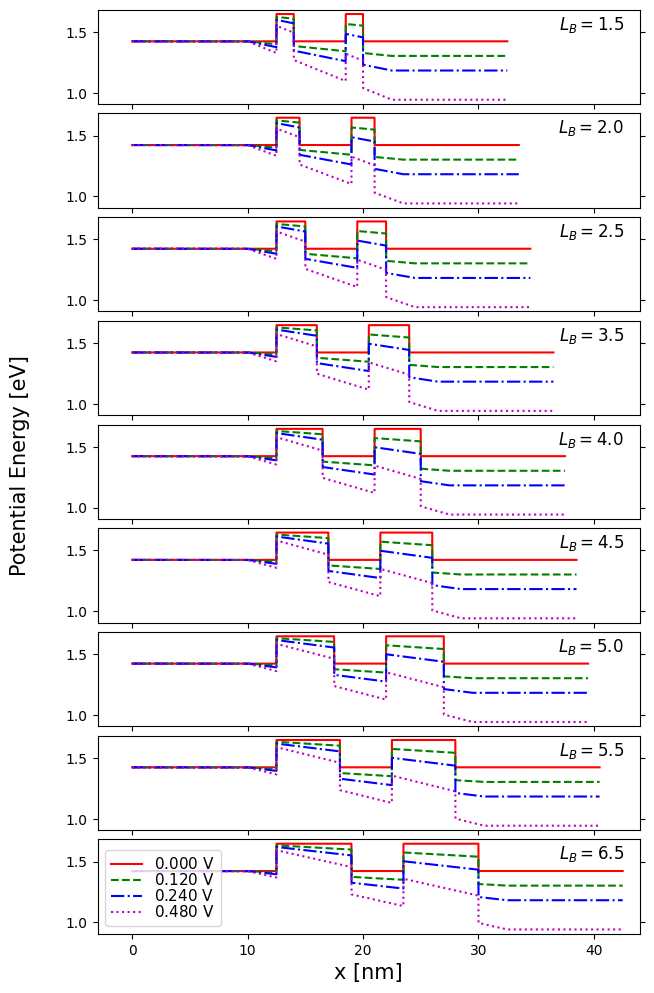

In [147]:
'''Plot bentuk potensial yang digunakan'''

fig, axes = plt.subplots(len(LebarPenghalangplot), 1, sharex=True, figsize=(7, 12))
fig.subplots_adjust(hspace=0.1)  #jarak antar subplot

for (ax, i) in zip(axes, LebarPenghalangplot):
  for T in Tplot:
    xi       = eval(f'x_LB{str(i).replace(".", "_")}_T{T}')
    pot_0    = eval(f'pot_LB{str(i).replace(".", "_")}_T{T}')[0]
    pot_i    = eval(f'pot_LB{str(i).replace(".", "_")}_T{T}')[n]
    pot_j    = eval(f'pot_LB{str(i).replace(".", "_")}_T{T}')[n2]
    pot_k    = eval(f'pot_LB{str(i).replace(".", "_")}_T{T}')[n3]

    ax.plot(xi, pot_0, color='r', linestyle='-', label=f'$0.000$ V')
    ax.plot(xi, pot_i, color='g', linestyle='--', label=f'${Vplot:.3f}$ V')
    ax.plot(xi, pot_j, color='b', linestyle='-.', label=f'${Vplot2:.3f}$ V')
    ax.plot(xi, pot_k, color='m', linestyle=':', label=f'${Vplot3:.3f}$ V')

    ax.text(0.97, 0.95, f"$L_B = {i}$", fontsize=12, ha='right', va='top',
            transform=ax.transAxes)

    ax.tick_params(right=True, which='both')

#Label sumbu
axes[-1].set_xlabel('x [nm]', fontsize= 15)
fig.text(0, 0.5, 'Potential Energy [eV]', fontsize=15, va='center', rotation='vertical')
plt.xlim(-3, 44)

plt.legend(labelspacing=0, fontsize=11, loc='lower left')
plt.show()


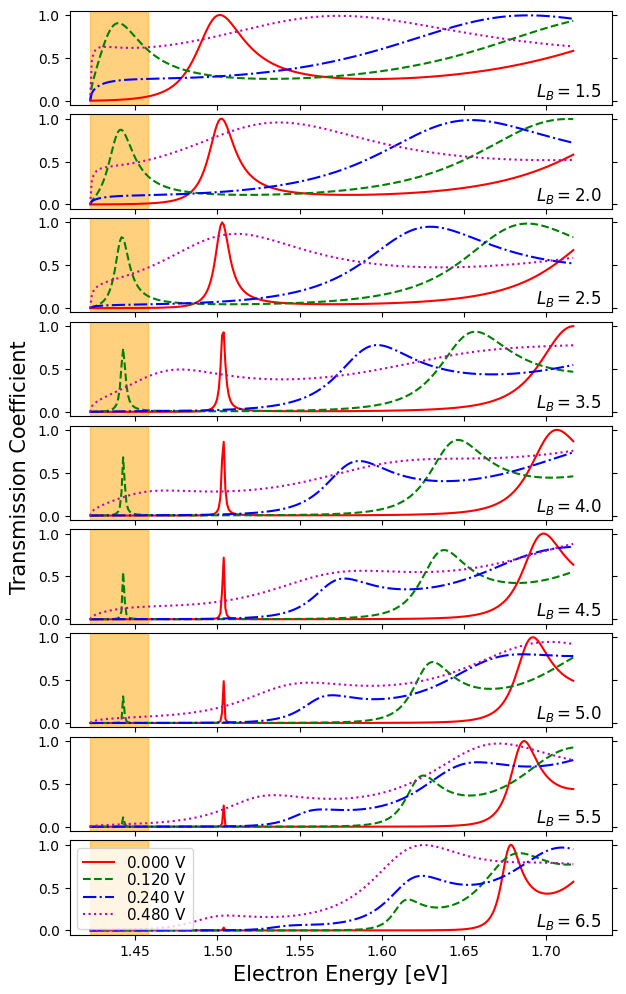

In [148]:
'''Plot koefisien transmisi'''

fig, axes = plt.subplots(len(LebarPenghalangplot), 1, sharex=True, figsize=(7, 12))
fig.subplots_adjust(hspace=0.1)  #jarak antar subplot

for (ax, i) in zip(axes, LebarPenghalangplot):
  for T in Tplot:
    Tr_0    = eval(f'nilai_transmisi_LB{str(i).replace(".", "_")}_T{T}')[0]
    Tr_1    = eval(f'nilai_transmisi_LB{str(i).replace(".", "_")}_T{T}')[n]
    Tr_2    = eval(f'nilai_transmisi_LB{str(i).replace(".", "_")}_T{T}')[n2]
    Tr_3    = eval(f'nilai_transmisi_LB{str(i).replace(".", "_")}_T{T}')[n3]

    ax.axvspan(Energi[0], Ef, color='orange', alpha=0.5)
    ax.plot(Energi, Tr_0, color='r', linestyle='-', label=f'$0.000$ V')
    ax.plot(Energi, Tr_1, color='g', linestyle='--', label=f'${Vplot:.3f}$ V')
    ax.plot(Energi, Tr_2, color='b', linestyle='-.', label=f'${Vplot2:.3f}$ V')
    ax.plot(Energi, Tr_3, color='m', linestyle=':', label=f'${Vplot3:.3f}$ V')

    ax.text(0.98, 0.25, f"$L_B = {i}$", fontsize=12, ha='right', va='top',
            transform=ax.transAxes)
    ax.tick_params(right=True, which='both')

#Label sumbu
axes[-1].set_xlabel('Electron Energy [eV]', fontsize = 15)
fig.text(0.04, 0.5, 'Transmission Coefficient', fontsize = 15, va='center', rotation='vertical')
plt.xlim(1.41, 1.74)

plt.legend(labelspacing=0.1, fontsize=11, loc='upper left')
plt.show()


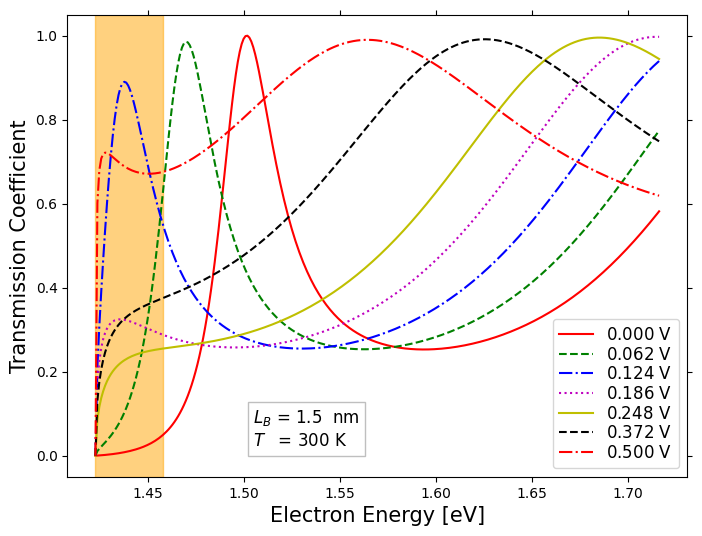

In [149]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

plt.figure(figsize=(8, 6))
biasx = [0, 0.062, 0.124, 0.186, 0.248, 0.372, 0.5]
LebarPenghalangx = [1.5]
for i in LebarPenghalangx:
  for T in Tplot:
    for V in biasx:
      Tr_x = eval(f'nilai_transmisi_LB{str(i).replace(".", "_")}_T{T}')[np.argmin(np.abs(Vbias - V))]
      plt.plot(Energi, Tr_x, color=next(colors), linestyle=next(linestyles), label=f'${Vbias[np.argmin(np.abs(Vbias-V))]:.3f}$ V')

plt.axvspan(Energi[0], Ef, color='orange', alpha=0.5)
plt.xlabel("Electron Energy [eV]", fontsize = 15)
plt.ylabel(f"Transmission Coefficient", fontsize = 15)

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.legend(labelspacing=0.1, loc = 'lower right', fontsize=12)
plt.text(0.3, 0.15, f'$L_B$ = {LebarPenghalangx[0]}  nm\n$T_ $  = {Temperature[0]} K', fontsize = 12,
         transform=plt.gca().transAxes, verticalalignment='top', color='k',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

plt.show()

#MP4 Koefisien Transmisi

In [150]:
LB_x    = 1.5
T_x     = Temperature[0]
Tr_MP4  = eval(f'nilai_transmisi_LB{str(LB_x).replace(".", "_")}_T{T_x}')
J_MP4   = eval(f'J_LB{str(LB_x).replace(".", "_")}_T{T_x}')
J_MP4   = J_MP4/(1e9)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#Grafik kiri: Transmisi Elektron
line1, = ax1.plot(Energi, Tr_MP4[0], color='red', lw=2)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Electron Energy [eV]', fontsize = 15)
ax1.set_ylabel('Transmission Coefficient' , fontsize = 15)
ax1.axvspan(Energi[0], Ef, color='orange', alpha=0.5)
ax1.tick_params(top=True, right=True, which='both')

#Grafik kanan: I-V Curve
ax2.plot(Vbias, J_MP4, color='blue', lw=2)
dot, = ax2.plot([], [], 'o', color='r')  #Titik bergerak
ax2.set_xlabel('Bias Voltage [V]', fontsize = 15)
ax2.set_ylabel('Current Density [kA/cm$^2$]', fontsize = 15)
ax2.tick_params(top=True, right=True, which='both')

plt.tight_layout()
plt.close(fig)
text_info = ax2.text(0.05, 0.95, '', transform=ax2.transAxes,
                     ha='left', va='top', fontsize=10, fontfamily='monospace',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
def animate(i):
    line1.set_ydata(Tr_MP4[i])
    dot.set_data([Vbias[i]], [J_MP4[i]])
    text_info.set_text(
      f'{"LB":<5}= {LB_x}   nm\n'
      f'{"T":<5}= {T_x}   K\n'
      f'{"Bias":<5}= {Vbias[i]:.3f} V\n'
      f'{"J":<5}= {J_MP4[i]:.3f} kA/cm²')

    return line1, dot, text_info

ani = FuncAnimation(fig, animate, frames=len(Vbias), interval=150, blit=True)
HTML(ani.to_html5_video())


#J-V Characteristics

In [151]:
LebarPenghalang_JV = LebarPenghalang
T_JV               = Temperature

In [152]:
'''Interpolasi Karakteristik J-V agar ditemukan puncak dan lembah yang lebih akurat'''

'''
Terdapat cukup banyak metode untuk menemukan J puncak dan J lembah pada karakteristik J-V.
1. Generate lansung data hasil TMM, dimana ketelitian tegangan bias maksimum yang dihasilkan dalam penelitian ini adalah 0.002S Volt
2. Generate data hasil TMM, kemudian melakukan diskretisasi bias lebih kecil pada daerah J puncak dan J lembah berbasis perhitungan TMM langsung.
   Ketelitian yang dihasilkan tergantung diskretisasi bias tersebut.
3. Generate data hasil TMM, kemudian menggunakan metode Golden Section dengan berbasis perhitungan TMM langsung untuk menemukan J puncak dan J lembah.
   Ketelitian yang dihasilkan tergantung banyak iterasi yang diinginkan.
4. Generate data hasil TMM, kemudian menggunakan interpolasi agar diskretisasi bias semakin halus.
   Ketelitian yang dihasilkan tergantung hasil interpolasi dan besarnya diskretisasi bias.
'''

#Nilai Vbias untuk interpolasi
dV_int    = 1e-6
Vbias_int0 = np.arange(0, 0.1, 1e-3)
Vbias_int1 = np.arange(0.1, 0.3, dV_int)
Vbias_int2 = np.arange(0.3, 0.5+1e-8, 1e-3)
Vbias_int = np.concatenate((Vbias_int0, Vbias_int1, Vbias_int2))

#Nilai J interpolasi
J_int = []
for i in LebarPenghalang_JV:
  for T in T_JV:
    J_val = eval(f'J_LB{str(i).replace(".", "_")}_T{T}')
    J_val = J_val/1e6/1e3                                     #Ubah satuan dalam kA/cm2 (Umumnya)
    f     = make_interp_spline(Vbias, J_val, k=3)
    J_int.append(f(Vbias_int))


'''Semua nilai J setelah code ini memiliki satuan kA/cm2'''

'Semua nilai J setelah code ini memiliki satuan kA/cm2'

In [153]:
'''Mencari Ip, Iv, Vp, dan Vv pada karakteristik J-V hasil interpolasi'''

peak   = []   #isinya (Vp, Ip) dengan urutan sesuai [LebarPenghalang]
valley = []   #isinya (Vv, Iv) dengan urutan sesuai [LebarPenghalang]

#Deteksi arus puncak dan arus lembah
for i in LebarPenghalang_JV:
  for T in T_JV:
      J_i      = J_int[LebarPenghalang_JV.index(i)]   #Hasil interpolasi

      #Filter data sampai batas tegangan
      batas_tegangan = 0.16     #tebakan
      mask           = Vbias_int < batas_tegangan
      J_mask         = J_i[mask]
      Vb_mask        = Vbias_int[mask]

      indekspuncak   = np.argmax(J_mask)
      J_max          = J_i[indekspuncak]
      Vbias_J_max    = Vbias_int[indekspuncak]

      #Cari lembah setelah puncak di data penuh
      indekslembah   = np.argmin(J_i[indekspuncak:]) + indekspuncak
      J_min          = J_i[indekslembah]
      Vbias_J_min    = Vbias_int[indekslembah]

      peak.extend(np.column_stack((Vbias_J_max, J_max)))
      valley.extend(np.column_stack((Vbias_J_min, J_min)))

peak    = np.array(peak)
valley  = np.array(valley)

#Menghitung Selisih Kerapatan Arus dan Tegangan
peak_LB   = [peak[i:i+1] for i in range(0, len(peak), 1)]
valley_LB = [valley[i:i+1] for i in range(0, len(valley), 1)]
Delta_J   = [p[0][1] - v[0][1] for p, v in zip(peak_LB, valley_LB)]
Delta_V   = [v[0][0] - p[0][0] for p, v in zip(peak_LB, valley_LB)]

#Menghitung Daya RF Maksimum Per-Luas
P_RF_max = [3/16 * Delta_J[i] * Delta_V[i] for i in range(len(Delta_J))]

#Menghitung Peak-to-valley-ratio (PVR)
PVR       = [p[0][1] / v[0][1] for p, v in zip(peak_LB, valley_LB)]

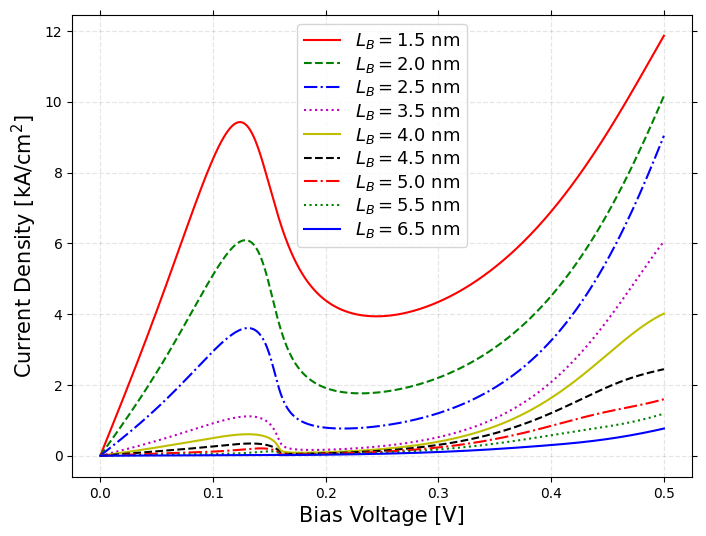

In [154]:
'''Plot J-V Characteristics'''

colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

plt.figure(figsize=(8, 6))

for i in LebarPenghalang_JV:
  for T in T_JV:
    J_i = J_int[LebarPenghalang_JV.index(i)]
    plt.plot(Vbias_int, J_i, color=next(colors), linestyle=next(linestyles), label=f'$L_B = {i}$ nm')

#plt.title("J-V Characteristics of Double-Barrier RTDs", fontsize=10)
plt.xlabel("Bias Voltage [V]", fontsize = 15)
plt.ylabel(f"Current Density [kA/cm$^2$]", fontsize = 15)

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc = 'upper center', fontsize=13)

plt.show()

In [155]:
'''Mencoba menampilkan data'''

import pandas as pd

column_order = ['LB', 'Vp', 'Jp']
column_order_valley = ['LB', 'Vv', 'Jv']

df_peak = pd.DataFrame(peak, columns=['Vp', 'Jp']).assign(LB=LebarPenghalang_JV)[column_order]
df_valley = pd.DataFrame(valley, columns=['Vv', 'Jv']).assign(LB=LebarPenghalang_JV)[column_order_valley]

display(df_peak)
display(df_valley)

data = {'LB': LebarPenghalang_JV, 'PVR' : PVR,'dJ': Delta_J, 'dV': Delta_V, 'Power RF (unit Area)': P_RF_max}
df = pd.DataFrame(data)

display(df)

,LB,Vp,Jp
0,1.5,0.123884,9.428006
1,2.0,0.128730,6.090170
2,2.5,0.131036,3.607701
3,3.5,0.131621,1.113604
4,4.0,0.131029,0.607456
5,4.5,0.133702,0.345186
6,5.0,0.142028,0.208567
7,5.5,0.150143,0.123531
8,6.5,0.156930,0.025003


,LB,Vv,Jv
0,1.5,0.244973,3.938841
1,2.0,0.231002,1.762190
2,2.5,0.215459,0.768212
3,3.5,0.187944,0.162752
4,4.0,0.177750,0.085316
5,4.5,0.170343,0.050756
6,5.0,0.160988,0.032992
7,5.5,0.160829,0.021413
8,6.5,0.160728,0.017134


,LB,PVR,dJ,dV,Power RF (unit Area)
0,1.5,2.393599,5.489165,0.121089,0.124627
1,2.0,3.456023,4.327980,0.102272,0.082993
2,2.5,4.696233,2.839489,0.084423,0.044947
3,3.5,6.842351,0.950852,0.056323,0.010042
4,4.0,7.120105,0.522140,0.046721,0.004574
5,4.5,6.800901,0.294430,0.036641,0.002023
6,5.0,6.321719,0.175575,0.018960,0.000624
7,5.5,5.769076,0.102118,0.010686,0.000205
8,6.5,1.459300,0.007869,0.003798,0.000006


In [156]:
from google.colab import files
df_peak.to_excel('output_peak.xlsx', index=False)
#files.download('output_peak.xlsx')
df_valley.to_excel('output_valley.xlsx', index=False)
#files.download('output_valley.xlsx')

#PVCR

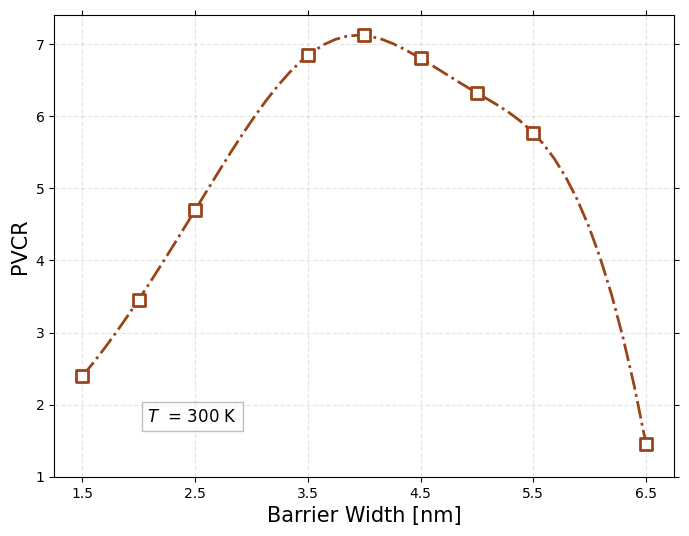

In [157]:
'''Peak-to-valley-current-ratio'''

plt.figure(figsize=(8, 6))

xp_1, yp_1 = interpolasi(min(LebarPenghalang_JV), max(LebarPenghalang_JV), 3, LebarPenghalang_JV, PVR, 50)
plt.plot(xp_1, yp_1, color='#994519', linestyle='-.', lw=2)

plt.scatter(LebarPenghalang_JV, PVR, marker='s', s=70, c='w', ec='#994519', lw=2, zorder=3)

plt.xlabel('Barrier Width [nm]', fontsize=15)
plt.ylabel('PVCR', fontsize=15)
#plt.title('Peak-to-valley-current-ratio', fontsize=10)

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.text(0.15, 0.15, f'$T$  = {Temperature[0]} K', fontsize = 12,
         transform=plt.gca().transAxes, verticalalignment='top', color='k',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
plt.ylim(1)
plt.show()

#Power RF

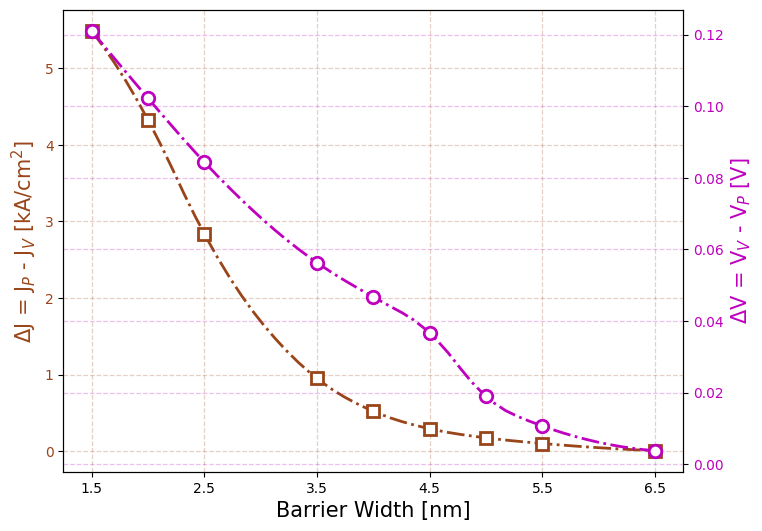

In [158]:
'''Plot dJ dan dV'''

fig, ax1 = plt.subplots(figsize=(8, 6))

color = '#994519'
ax1.set_xlabel('Barrier Width [nm]', fontsize=15)
ax1.set_xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax1.set_ylabel('$\Delta$J = J$_P$ - J$_V$ [kA/cm$^2$]', fontsize=15, color=color)

xp_1, yp_1 = interpolasi(min(LebarPenghalang_JV), max(LebarPenghalang_JV), 2, LebarPenghalang_JV, Delta_J, 50)
ax1.plot(xp_1, yp_1, color=color, linestyle='-.', lw=2)
ax1.plot(LebarPenghalang_JV, Delta_J, linestyle='None', marker='s', markersize=9, markerfacecolor='w', markeredgecolor=color, markeredgewidth=2)

ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.grid(True, linestyle='--', linewidth=0.9, alpha=0.25, color=color)

ax2 = ax1.twinx()
color = 'm'
ax2.set_ylabel('$\Delta$V = V$_V$ - V$_P$ [V]', fontsize=15, color=color)

xp_1, yp_1 = interpolasi(min(LebarPenghalang_JV), max(LebarPenghalang_JV), 2, LebarPenghalang_JV, Delta_V, 50)
ax2.plot(xp_1, yp_1, color=color, linestyle='-.', lw=2)
ax2.plot(LebarPenghalang_JV, Delta_V, linestyle='None', marker='o', markersize=9, markerfacecolor='w', markeredgecolor=color, markeredgewidth=2)

ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, linestyle='--', linewidth=0.9, alpha=0.25, color=color)

#plt.title('$\Delta$J and $\Delta$V vs Barrier Width', fontsize=10)
plt.show()


-0.07967986430841566 0.24354890854673822
2.29099092055829 -1.568050052802005


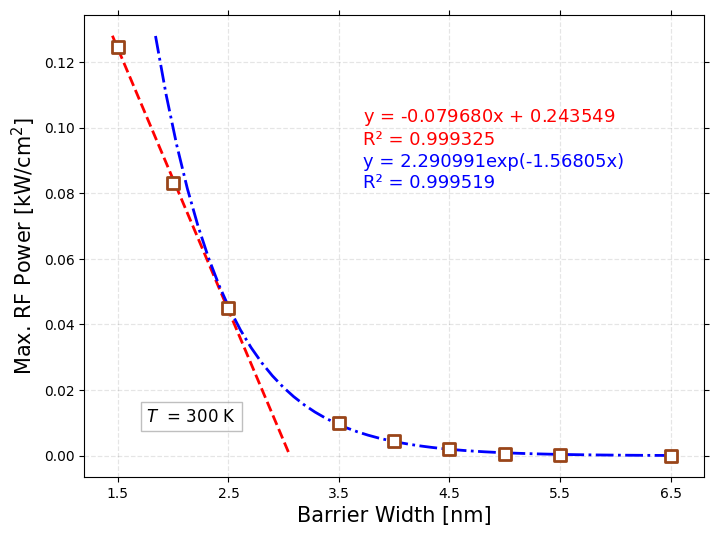

In [159]:
'''Plot Max_RF Power'''

plt.figure(figsize=(8, 6))

plt.scatter(LebarPenghalang_JV, P_RF_max, marker='s', s=70, c='w', ec='#994519', lw=2, zorder=3)

#Trendline 1.5 hingga 2.5 nm adalah linear
slope, intercept  = np.polyfit(LebarPenghalang_JV[:3], P_RF_max[:3], 1)
reg               = slope*np.array(LebarPenghalang_JV[:3]) + intercept
r_squared         = r2_score(P_RF_max[:3], reg)

xp_1 = np.linspace(min(LebarPenghalang_JV[:3])-0.05, max(LebarPenghalang_JV[:3])+0.55, 50)
yp_1 = slope*xp_1 + intercept
plt.plot(xp_1, yp_1, color='r', linestyle='--', lw=2)
plt.text(0.45, 0.8, f'y = {slope:.6f}x $\plus$ {intercept:.6f}\nR² = {r_squared:.6f}',
         transform=plt.gca().transAxes, verticalalignment='top', color='r',
         fontsize=13)
print(slope, intercept)

#Trendline 2.5 hingga 6.5 nm adalah eksponensial
slope, intercept  = np.polyfit(LebarPenghalang_JV[2:], np.log(P_RF_max[2:]), 1, w=np.sqrt(P_RF_max[2:]))
intercept         = np.exp(intercept)
reg               = intercept*np.exp(slope*np.array(LebarPenghalang_JV[2:]))
r_squared         = r2_score(P_RF_max[2:], reg)

xp_1 = np.linspace(min(LebarPenghalang_JV)+0.34, max(LebarPenghalang_JV)+0.05, 50)
yp_1 = intercept*np.exp(slope*xp_1)

plt.plot(xp_1, yp_1, color='b', linestyle='-.', lw=2)
plt.text(0.45, 0.7, f'y = {intercept:.6f}exp({slope:.6}x)\nR² = {r_squared:.6f}',
         transform=plt.gca().transAxes, verticalalignment='top', color='b',
         fontsize=13)
print(intercept, slope)

plt.xlabel('Barrier Width [nm]', fontsize=15)
plt.ylabel(f'Max. RF Power [kW/cm$^2$]', fontsize=15)
#plt.title('Maximum RF Power vs Barrier Width', fontsize=10)

plt.text(0.1, 0.15, f'$T$  = {Ti} K', fontsize = 12,
         transform=plt.gca().transAxes, verticalalignment='top', color='k',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

plt.show()